## Import stuff and load calculations

In [1]:
import matplotlib.patheffects as path_effects
import matplotlib.pyplot as plt
import numpy as np
import os, sys
sys.path.append(f"{os.path.dirname(os.getcwd())}/scripts")

In [2]:
# from creative_and_factual_metrics import *

In [3]:
from sentence_transformers import SentenceTransformer
from diversity_metrics.metrics.model_free_metrics import *
from diversity_metrics.embeddings.models import *
from diversity_metrics.metrics.generalized_diversity import *

In [4]:
pythia_28b_results_5_words  = np.load(f"{os.path.dirname(os.getcwd())}/results/creative_factual/pythia-2.8b_results_5_words.npy", allow_pickle=True).item()
pythia_28b_sft_results_5_words  = np.load(f"{os.path.dirname(os.getcwd())}/results/creative_factual/pythia-2.8b-sft_results_5_words.npy", allow_pickle=True).item()
pythia_28b_dpo_results_5_words  = np.load(f"{os.path.dirname(os.getcwd())}/results/creative_factual/pythia-2.8b-dpo_results_5_words.npy", allow_pickle=True).item()

pythia_28b_results_20_words  = np.load(f"{os.path.dirname(os.getcwd())}/results/creative_factual/pythia-2.8b_results_20_words.npy", allow_pickle=True).item()
pythia_28b_sft_results_20_words  = np.load(f"{os.path.dirname(os.getcwd())}/results/creative_factual/pythia-2.8b-sft_results_20_words.npy", allow_pickle=True).item()
pythia_28b_dpo_results_20_words  = np.load(f"{os.path.dirname(os.getcwd())}/results/creative_factual/pythia-2.8b-dpo_results_20_words.npy", allow_pickle=True).item()


## Functions

In [9]:
temperatures = [k / 10. for k in range(1, 16)]
temperatures 

[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5]

In [10]:
from functools import partial

def limit_num_words(sentence, max_num_words):
    return " ".join(sentence.split()[:max_num_words])


def average_pairwise_jaccard(sentences, n=2):
    return np.mean([pairwise_ngram(n, x, y) for x, y in combinations(sentences, 2)])

def self_bleu_smooth(sentences):
    '''
    Calculates the Self-BLEU score for a collection of generated examples (https://arxiv.org/abs/1802.01886)
    :param sentences: List of generated examples
    :return:
    '''

    scores = []
    for i, hypothesis in enumerate(sentences):
        hypothesis_split = hypothesis.strip().split()

        references = [sentences[j].strip().split() for j in range(len(sentences)) if i != j]

        scores.append(sentence_bleu(references, hypothesis_split, smoothing_function=SmoothingFunction().method1))

    return sum(scores) / len(scores)

diversity_metrics = {"selfBleuSmoothed": self_bleu_smooth,
                    "average_pairwise_ncd": lambda sentences: np.mean(get_pairwise_ncd(sentences)),
                     "average_pairwise_jaccard_2": partial(average_pairwise_jaccard, n=2),
                    "average_pairwise_jaccard_3": partial(average_pairwise_jaccard, n=3),
                    "average_pairwise_jaccard_4": partial(average_pairwise_jaccard, n=4),
                    "avg_compression_ratio_full": avg_compression_ratio_full,
                    "avg_compression_ratio_target": avg_compression_ratio_target,
                    "cosine_similarity": None # will be filled in later
                    }

## Plot output diversity metrics

In [11]:
metric_label = ["Self Bleu Smoothed", "Self Bleu Smoothed", "Average Pairwise NCD", "Average Pairwise NCD", 
               "Average Pairwise Jaccard 2", "Average Pairwise Jaccard 2", "Average Pairwise Jaccard 3", 
               "Average Pairwise Jaccard 3", "Average Pairwise Jaccard 4", "Average Pairwise Jaccard 4", 
               "Average Compression Ratio Full", "Average Compression Ratio Full","Average Compression Ratio Target", 
               "Average Compression Ratio Target", "Cosine Similarity", "Cosine Similarity"]

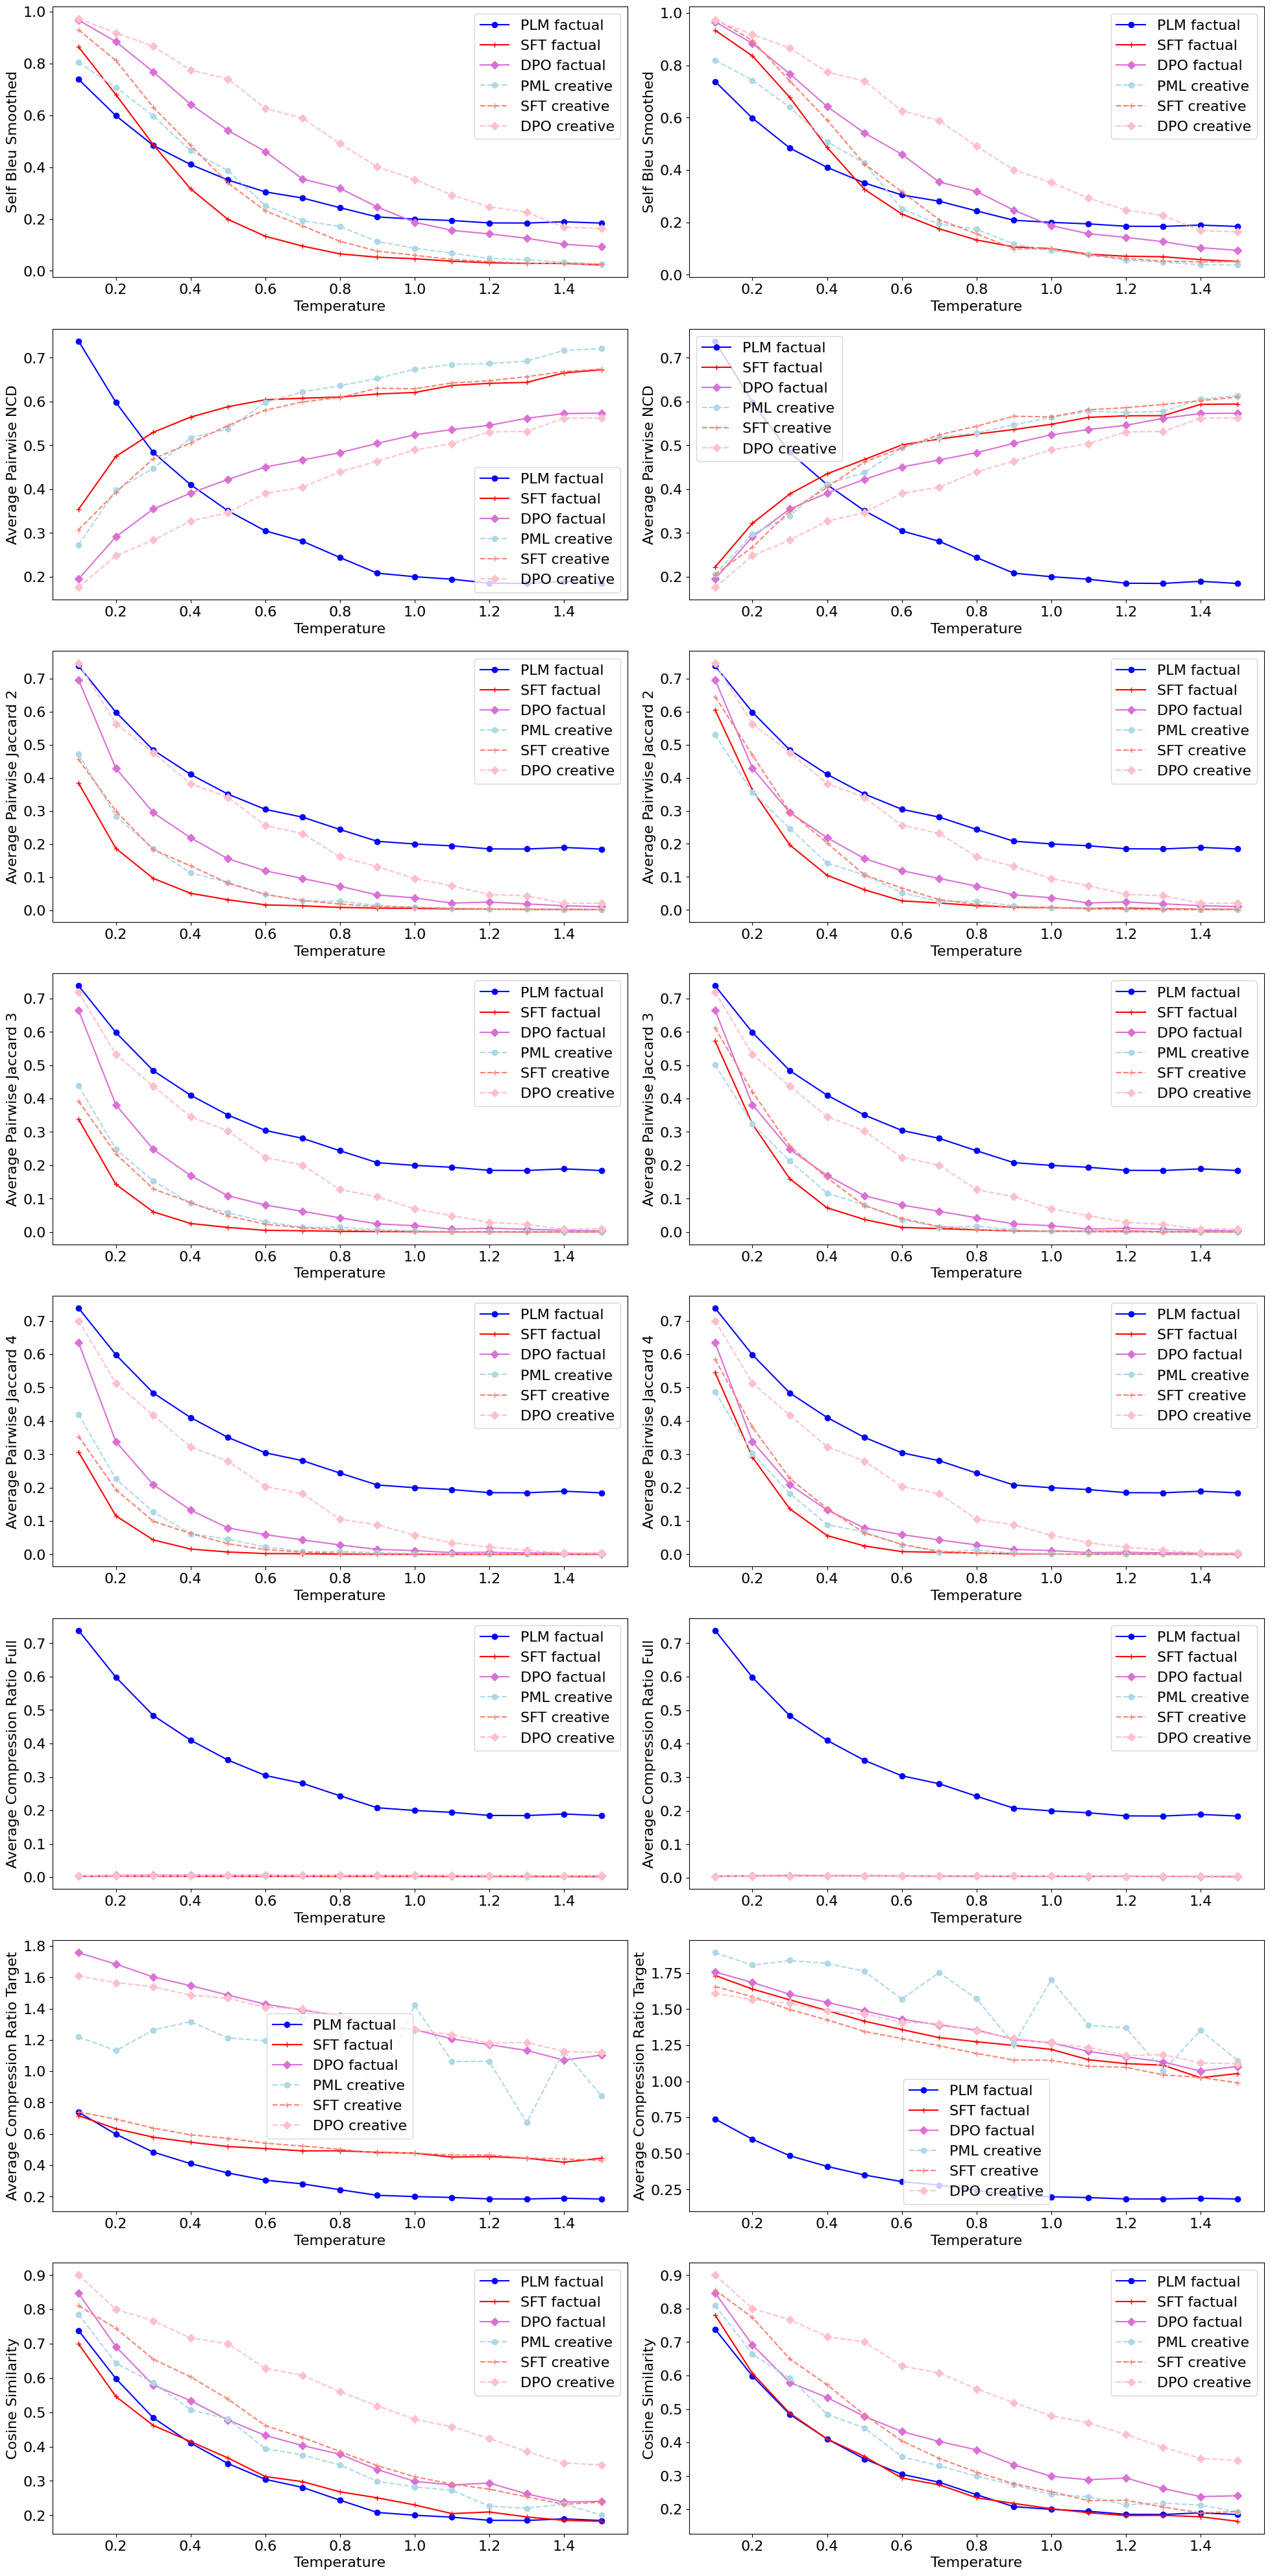

In [28]:
creative_factual_full_f = f"{os.path.dirname(os.getcwd())}/results/creative_factual_full.png"

num_metrics = len(diversity_metrics.keys())
fig, axes = plt.subplots(num_metrics, 2, figsize=(20, 5*num_metrics))
# make font bigger
plt.rcParams.update({'font.size': 16})

text_effect = [path_effects.withStroke(linewidth=3, foreground='white')]

i=0
for index, metric in enumerate(diversity_metrics.keys()):

    for col_idx, result_sft in enumerate([pythia_28b_sft_results_20_words, pythia_28b_sft_results_5_words]):
        ax = axes[index, col_idx]

        scores_factual_sft = result_sft["factual"][metric]
        scores_creative_sft = result_sft["creative"][metric]

        result_plm = [pythia_28b_results_20_words, pythia_28b_results_5_words][col_idx]
        scores_factual_plm = result_plm["factual"][metric]
        scores_creative_plm = result_plm["creative"][metric]

        result_other_dpo = [pythia_28b_dpo_results_20_words, pythia_28b_dpo_results_5_words][col_idx]
        scores_factual_dpo = result_dpo["factual"][metric]
        scores_creative_dpo = result_dpo["creative"][metric]

        # Plotting for factual scores
        ax.plot(temperatures, np.nanmean(scores_factual[:, :, 0],axis=1), label='pythia-2.8b-sft factual', marker='o', color="blue")
        ax.plot(temperatures, np.nanmean(scores_factual_plm[:, :, 0],axis=1), label='pythia2.8b factual', marker='+', color="red")
        ax.plot(temperatures, np.nanmean(scores_factual_dpo[:, :, 0],axis=1), label='pythia2.8b-dpo factual', marker='D', color="orchid")

        # Plotting for creative scores
        ax.plot(temperatures, np.nanmean(scores_creative_sft[:, :, 0],axis=1), label='pythia-2.8b-sft creative', marker='o', linestyle='--', color="lightblue")
        ax.plot(temperatures, np.nanmean(scores_creative_plm[:, :, 0],axis=1), label='pythia-2.8b creative', marker='+', linestyle='--', color="salmon")
        ax.plot(temperatures, np.nanmean(scores_creative_dpo[:, :, 0],axis=1), label='pythia-2.8b-dpo creative', marker='D', linestyle='--', color="pink")

        ax.set_xlabel('Temperature')
        ax.set_ylabel(metric_label[i])
        # text_effect = [path_effects.withStroke(linewidth=3, foreground='white')]
        ax.legend(['PLM factual', 'SFT factual', 'DPO factual', 'PML creative', 'SFT creative', 'DPO creative'])
        i+=1


plt.tight_layout()
plt.show()

fig.savefig(creative_factual_full_f, bbox_inches="tight") 
plt.close()

## Plot the difference in diversity between creative and factual changes for each model

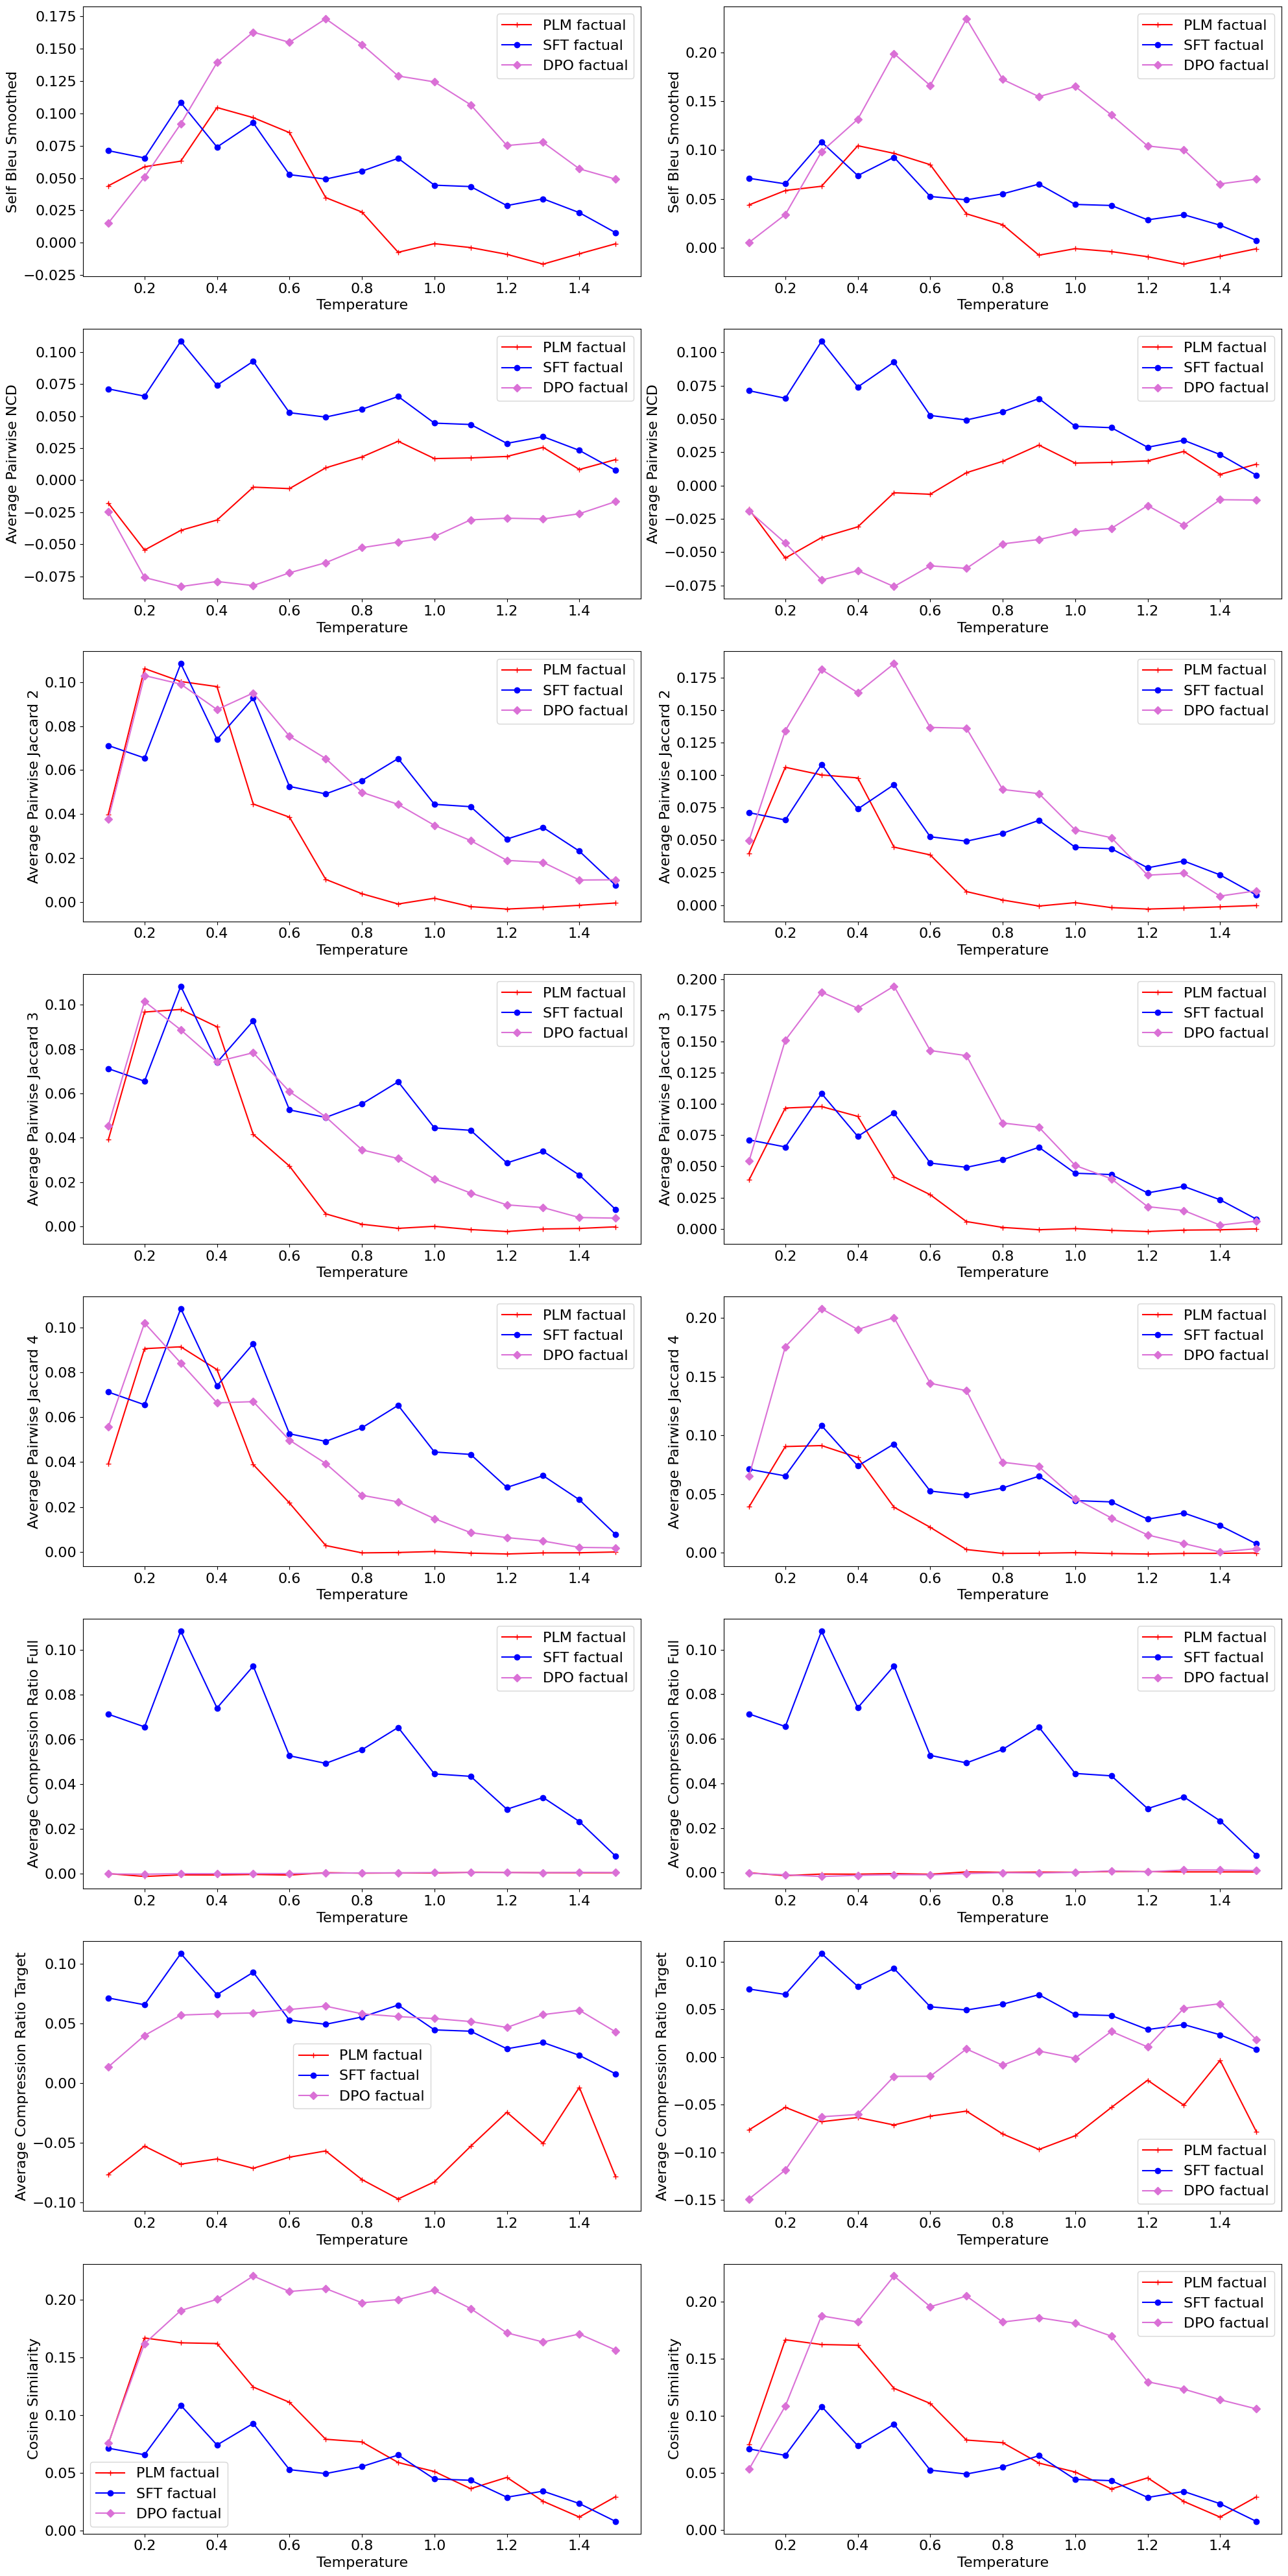

In [27]:
num_metrics = len(diversity_metrics.keys())
fig, axes = plt.subplots(num_metrics, 2, figsize=(20, 5*num_metrics))
# make font bigger
plt.rcParams.update({'font.size': 16})
text_effect = [path_effects.withStroke(linewidth=3, foreground='white')]

i=0
for index, metric in enumerate(diversity_metrics.keys()):

    for col_idx, result_sft in enumerate([pythia_28b_sft_results_20_words, pythia_28b_sft_results_5_words]):
        ax = axes[index, col_idx]

        scores_factual_sft = result_sft["factual"][metric]
        scores_creative_sft = result_sft["creative"][metric]

        result_plm = [pythia_28b_results_20_words, pythia_28b_results_5_words][col_idx]
        scores_factual_plm = result_other["factual"][metric]
        scores_creative_plm = result_other["creative"][metric]

        result_dpo = [pythia_28b_dpo_results_20_words, pythia_28b_dpo_results_5_words][col_idx]
        scores_factual_dpo = result_dpo["factual"][metric]
        scores_creative_dpo= result_dpo["creative"][metric]

        # Calculate differences
        diff_sft = scores_creative[:, :, 0] - scores_factual[:, :, 0]
        diff_plm = scores_creative_plm[:, :, 0] - scores_factual_plm[:, :, 0]
        diff_dpo = scores_creative_dpo[:, :, 0] - scores_factual_dpo[:, :, 0]

        # Plotting differences
        ax.plot(temperatures, np.nanmean(diff_plm,axis=1), label='PLM', marker='+', color="red")
        ax.plot(temperatures, np.nanmean(diff_sft,axis=1), label='SFT', marker='o', color="blue")
        ax.plot(temperatures, np.nanmean(diff_dpo,axis=1), label='SFT', marker='D', color="orchid")
        
        ax.set_xlabel('Temperature')
        ax.set_ylabel(metric_label[i])
        ax.legend(['PLM factual', 'SFT factual', 'DPO factual', 'PLM creative', 'SFT creative', 'DPO creative'])
        i+=1

plt.tight_layout()
plt.show()

## Plot the difference in diversity between creative and factual changes for each step in the fine-tuning pipeline

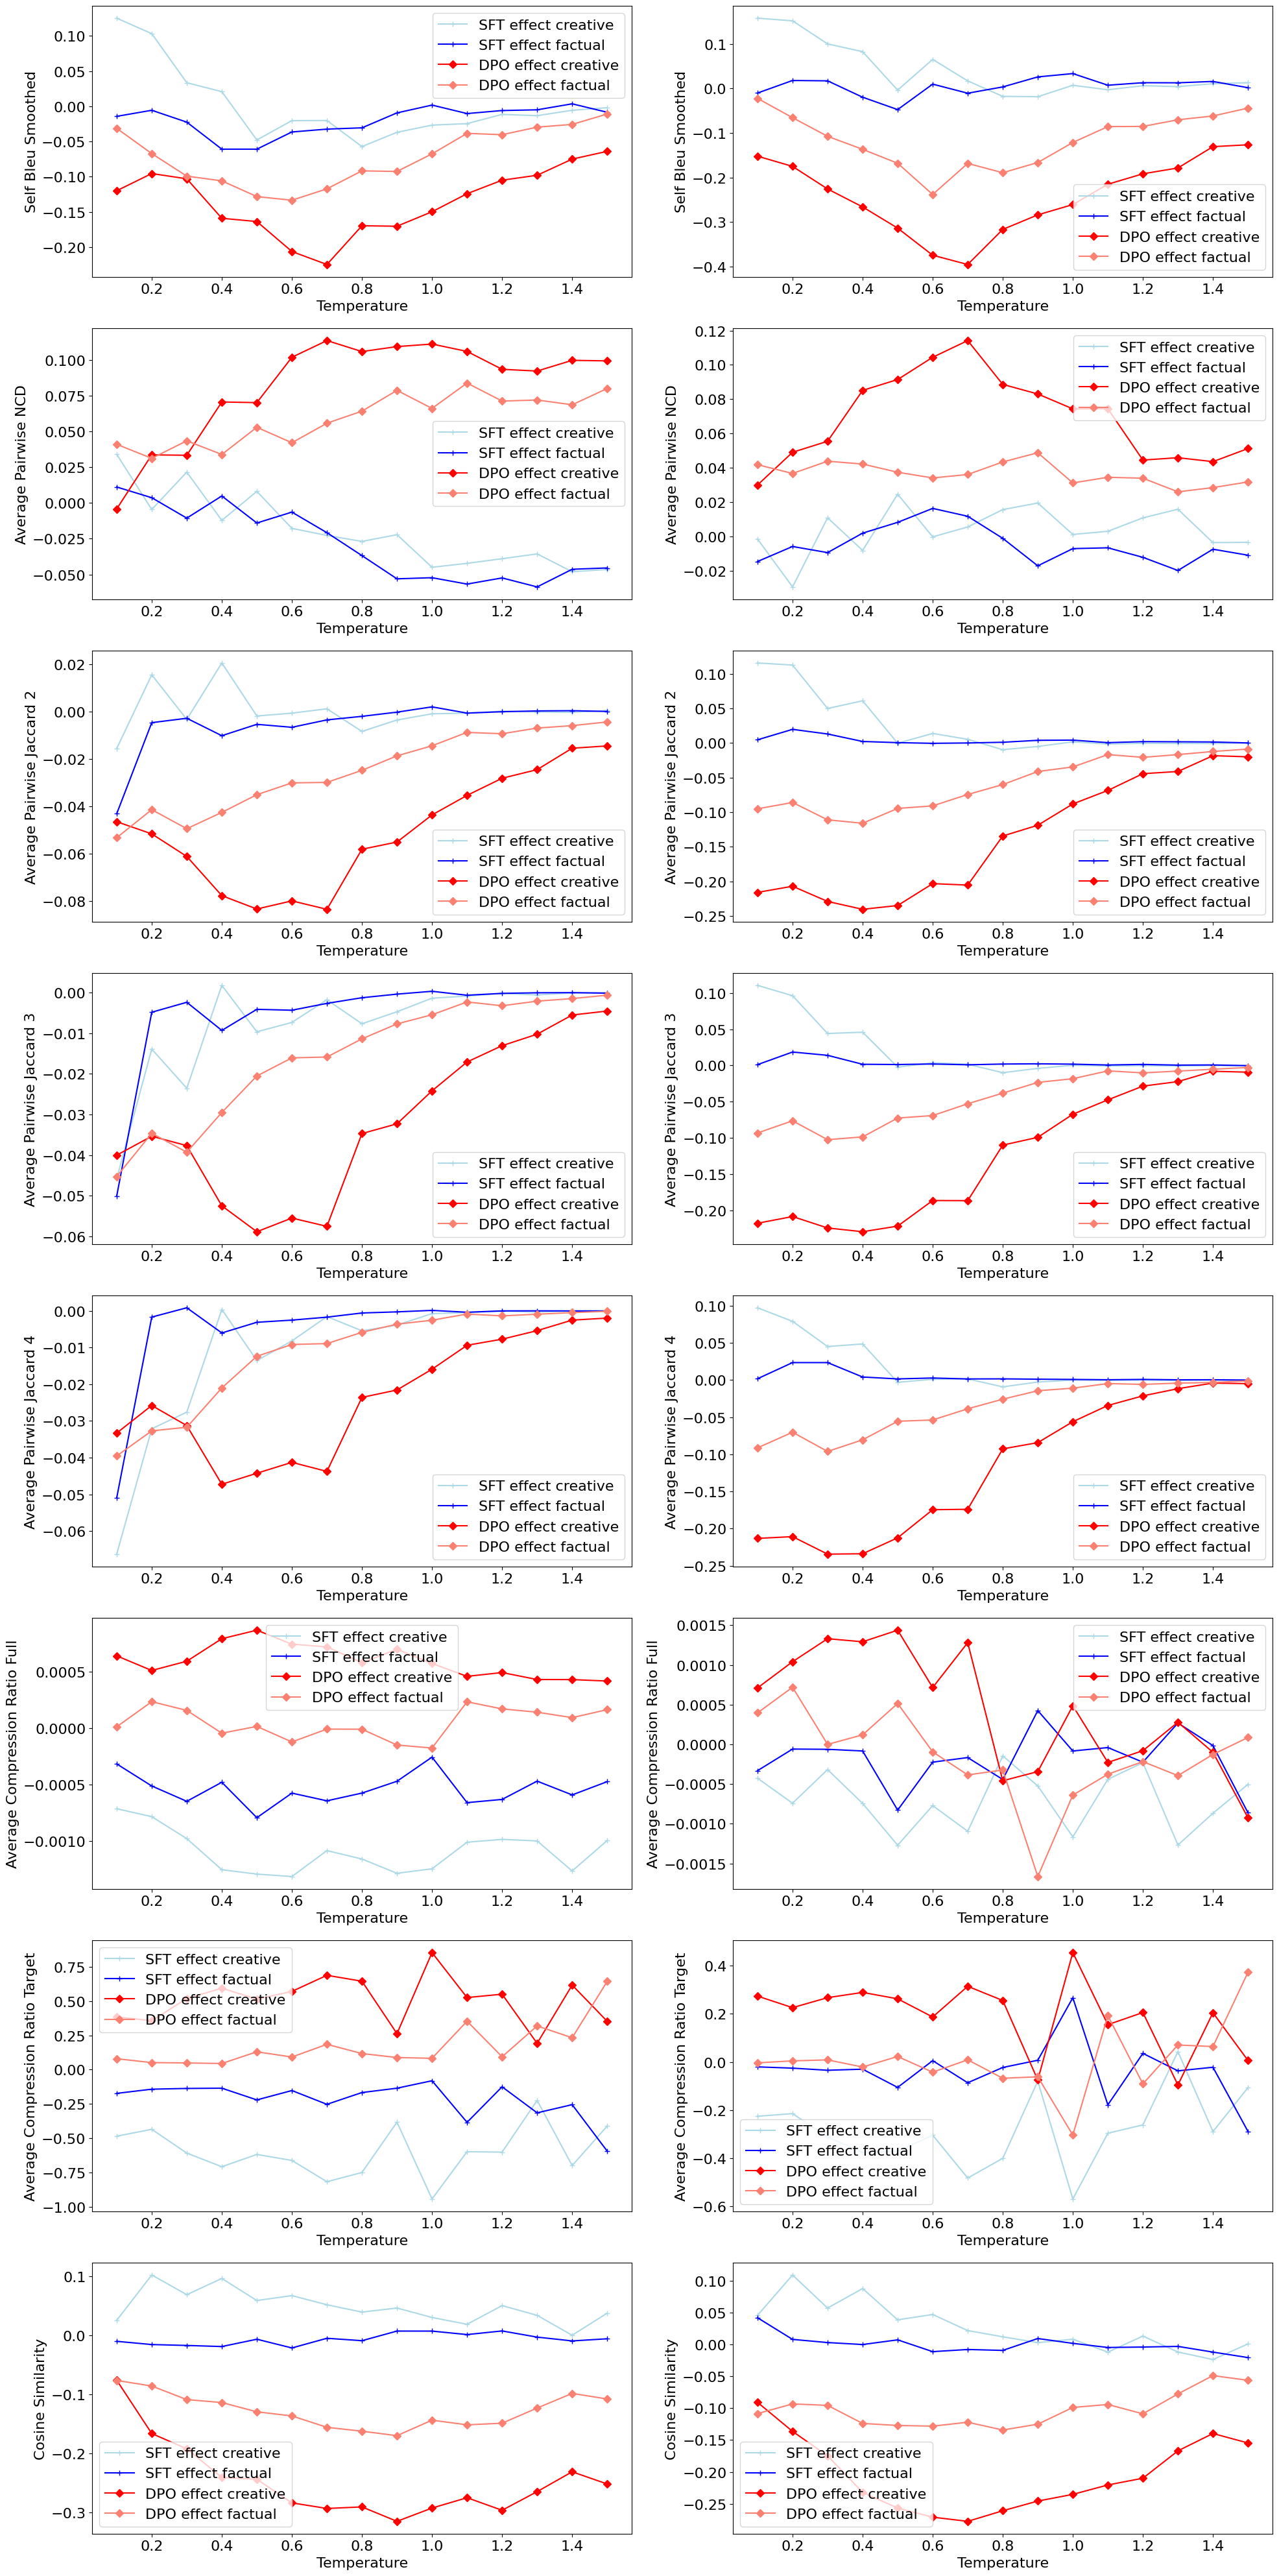

In [33]:
num_metrics = len(diversity_metrics.keys())
fig, axes = plt.subplots(num_metrics, 2, figsize=(20, 5*num_metrics))
# make font bigger
plt.rcParams.update({'font.size': 16})
text_effect = [path_effects.withStroke(linewidth=3, foreground='white')]

i=0
for index, metric in enumerate(diversity_metrics.keys()):

    for col_idx, result_sft in enumerate([pythia_28b_sft_results_20_words, pythia_28b_sft_results_5_words]):
        ax = axes[index, col_idx]

        scores_factual_sft = result_sft["factual"][metric]
        scores_creative_sft = result_sft["creative"][metric]

        result_plm = [pythia_28b_results_20_words, pythia_28b_results_5_words][col_idx]
        scores_factual_plm = result_plm["factual"][metric]
        scores_creative_plm = result_plm["creative"][metric]

        result_dpo = [pythia_28b_dpo_results_20_words, pythia_28b_dpo_results_5_words][col_idx]
        scores_factual_dpo = result_dpo["factual"][metric]
        scores_creative_dpo= result_dpo["creative"][metric]

        # Calculate differences
        diff_creative_plm_sft = scores_creative_plm[:, :, 0] - scores_creative_sft[:, :, 0]
        diff_factual_plm_sft = scores_factual_plm[:, :, 0] - scores_factual_sft[:, :, 0]
        diff_creative_sft_dpo = scores_creative_sft[:, :, 0] - scores_creative_dpo[:, :, 0]
        diff_factual_sft_dpo = scores_factual_sft[:, :, 0] - scores_factual_dpo[:, :, 0]

        # Plotting differences
        ax.plot(temperatures, np.nanmean(diff_creative_plm_sft,axis=1), label='SFT creative', marker='+', color="lightblue")
        ax.plot(temperatures, np.nanmean(diff_factual_plm_sft,axis=1), label='SFT factual', marker='+', color="blue")

        ax.plot(temperatures, np.nanmean(diff_creative_sft_dpo,axis=1), label='DPO creative', marker='D', color="red")
        ax.plot(temperatures, np.nanmean(diff_factual_sft_dpo,axis=1), label='DPO factual', marker='D', color="salmon")
        
        ax.set_xlabel('Temperature')
        ax.set_ylabel(metric_label[i])
        ax.legend(['SFT effect creative', 'SFT effect factual', 'DPO effect creative', 'DPO effect factual'])
        i+=1

plt.tight_layout()
plt.show()